In [5]:
#LIBRARIES
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import json
import time
import pydde as dde

#PARAMETERS
samplenum = 6
nTimeSteps = 30 #at 60Hz
batch_size = 2
filenum = int(samplenum/batch_size)
use_case = 'qhold'
sample_file_path = f'../Data/Samples/'
simulation_file_path = "../Data/Simulations/pm_target.sim"
objective_file_path = f'../Data/Objectives/pm_target_{nTimeSteps}.obj'
# set log level
dde.set_log_level(dde.LogLevel.off)

#SAMPLE TARGETS AND STARTS
y_target = np.zeros((samplenum,3))
y_target[:,0] = np.random.rand(samplenum)
y_target[:,1] = np.random.rand(samplenum)
y_target[:,2] = np.random.rand(samplenum)

############################################
#LOAD SIMULATION PYDDE_V2
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

#############################################
#LOAD OBJECTIVE PYDDE_V2
obj = dde.InverseObjective(dyn)
obj.loadFile(objective_file_path)
objective_json = json.load(open(objective_file_path))

#############################################
#GENERATE OPTIMIZATION PYDDE_V2
opt = dde.Newton()

In [6]:
####################################
#SAMPLE P PYDDE V2
start_time = time.time()

for b in range(filenum):
    data = {}
    data['parameter'] = []
    data['q_target'] = []
    data['loss'] = []
    data['iterations'] = []
    data['gradnorm'] = []
    for i in range(batch_size):
        objective_json["objectives"]["pmTargetPositions"][0]["targetPos"] = ([[y_target[b*batch_size+i,0]],[y_target[b*batch_size+i,1]],[y_target[b*batch_size+i,2]]]) 
        obj.loadJson(objective_json)
        p_i = opt.minimize(obj, p_init)
        data['q_target'].append(list(y_target[b*batch_size+i,:]))
        data['parameter'].append(list(p_i))
        data['loss'].append(obj.evaluate(p_i))
        #data['iterations'].append(params.iterations)
        #data['gradnorm'].append(params.grad)

    with open(sample_file_path + f'data_{b}.json', 'w') as outfile:
        json.dump(data, outfile)
    print(f'batch number {b+1} completed')
    print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed
    
#add description file
Description = {}
Description['Description'] = [{'samplenum': samplenum, 'samplesperfile': batch_size, 'time length': nTimeSteps, 'range from': [0, 2, 0], 'range to': [2, 0, 2]}]
with open(sample_file_path + 'Description.json', 'w') as outfile:
    json.dump(Description, outfile)

batch number 1 completed

Duration: 0.048 min
batch number 2 completed

Duration: 0.096 min
batch number 3 completed

Duration: 0.137 min


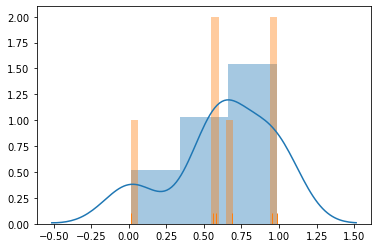

In [5]:
###############################
#PLOT DISTRIBUTION
import seaborn as sns
x = y_target[:, 0]
sns.distplot(x)
sns.distplot(x, bins=20, kde=False, rug=True)